## Section2 Part2 Visualize Correlation of coding gene density and eccDNA density on each chromosome
#### Ke Liu

In [1]:
import subprocess as sp
import numpy as np
import pandas as pd
import pysam as ps
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import scipy as sci
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator

In [2]:
methods = ['WGS-SR', 'WGS-LR', 'ATAC', '3SEP-SR', '3SEP-LR', 'Circle-seq-SR', 'Circle-seq-LR']
protocols = ['NGS_WGS', 'Nanopore_WGS', 'ATAC', 'DSAT', 'DSRT7', 'DNARCAU', 'DNRT7']
samples = ['{0}{1}'.format(a,b) for a in protocols for b in [1,2,3]]
methods_protocols = {'Circle-Seq-SR':'DNARCAU', '3SEP-SR':'DSARCAT', 'Circle-Seq-LR':'DNRT7', '3SEP-LR':'DSRT7', 'ATAC':'ATAC', 'WGS-SR':'NGS_WGS', 'WGS-LR':'Nanopore_WGS'}
protocols_methods = dict(zip(protocols, methods))
palette = {'DNRT7':'#ef6398', 'DNARCAU':'#f9b035', 'DSRT7':'#e35f5f', 'DSAT':'#fedd04', 'ATAC':'#52b97f','Nanopore_WGS': '#3bb3cf', 'NGS_WGS': '#377fb2'}
NGS_methods = ['NGS_WGS','ATAC','DSAT','DNARCAU']
Nanopore_methods = ['Nanopore_WGS', 'DSRT7', 'DNRT7']

#### 1 Calculate the length ratio of each chromotain

In [3]:
reference = '/home/qukun/liuke/reference/ucsc/hg38/hg38.fa'

In [4]:
def genome_length(genome = reference):
    #Get the length of each chromosome
    fasta = ps.Fastafile(genome)
    output = pd.DataFrame([fasta.lengths], columns=fasta.references, index=['length']).T
    output = output.drop(list(output.filter(regex='_',axis=0).index)+['chrM'])
    return output

In [5]:
genome_df = genome_length()

In [6]:
gtf = '/home/qukun/liuke/reference/GENCODE/hg38/gencode.v38.annotation.gtf'
gtf_table = pd.read_csv(gtf, sep ='\t', header=None, skiprows=5)

In [7]:
test = gtf_table[gtf_table[2]=='gene']
test.insert(9,9,test[8].apply(lambda x: x.split(';')[1].split('"')[1]))

In [9]:
density_plot = pd.DataFrame(0, index = ['chr{0}'.format(a) for a in list(range(1,23))+['X']], columns=['coding_gene'] + protocols)

In [10]:
for i in density_plot.index:
    density_plot.loc[i,'coding_gene'] =((len(test[(test[9]=='protein_coding')&(test[0]==i)])/ genome_df.loc[i,'length']))*1e6

#### 2  Read the result data 

In [11]:
NGS_path = '/home/qukun/liuke/workspace/benchmark/result/2nd/filtered/'
Nanopore_path = '/home/qukun/liuke/workspace/benchmark/result/3rd/filtered/'

In [12]:
for sample in ['{0}{1}'.format(a, b) for a in NGS_methods for b in [1,2,3]]:
    locals()[sample] = pd.read_csv(NGS_path + sample + '.bed',sep='\t',header=None)

In [13]:
for sample in ['{0}{1}'.format(a, b) for a in Nanopore_methods for b in [1,2,3]]:
    locals()[sample] = pd.read_csv(Nanopore_path + sample + '.bed',sep='\t',header=None)

#### 3 Calculate the normlize ratio of each chromatin

In [14]:
for sample in ['{0}{1}'.format(a, b) for a in protocols for b in [1,2,3]]:
    temp = pd.DataFrame(locals()[sample][0].value_counts())
    for i in temp.index:
        density_plot.loc[i, sample[:-1]] += ((temp.loc[i,0])/ genome_df.loc[i,'length'])*1e6

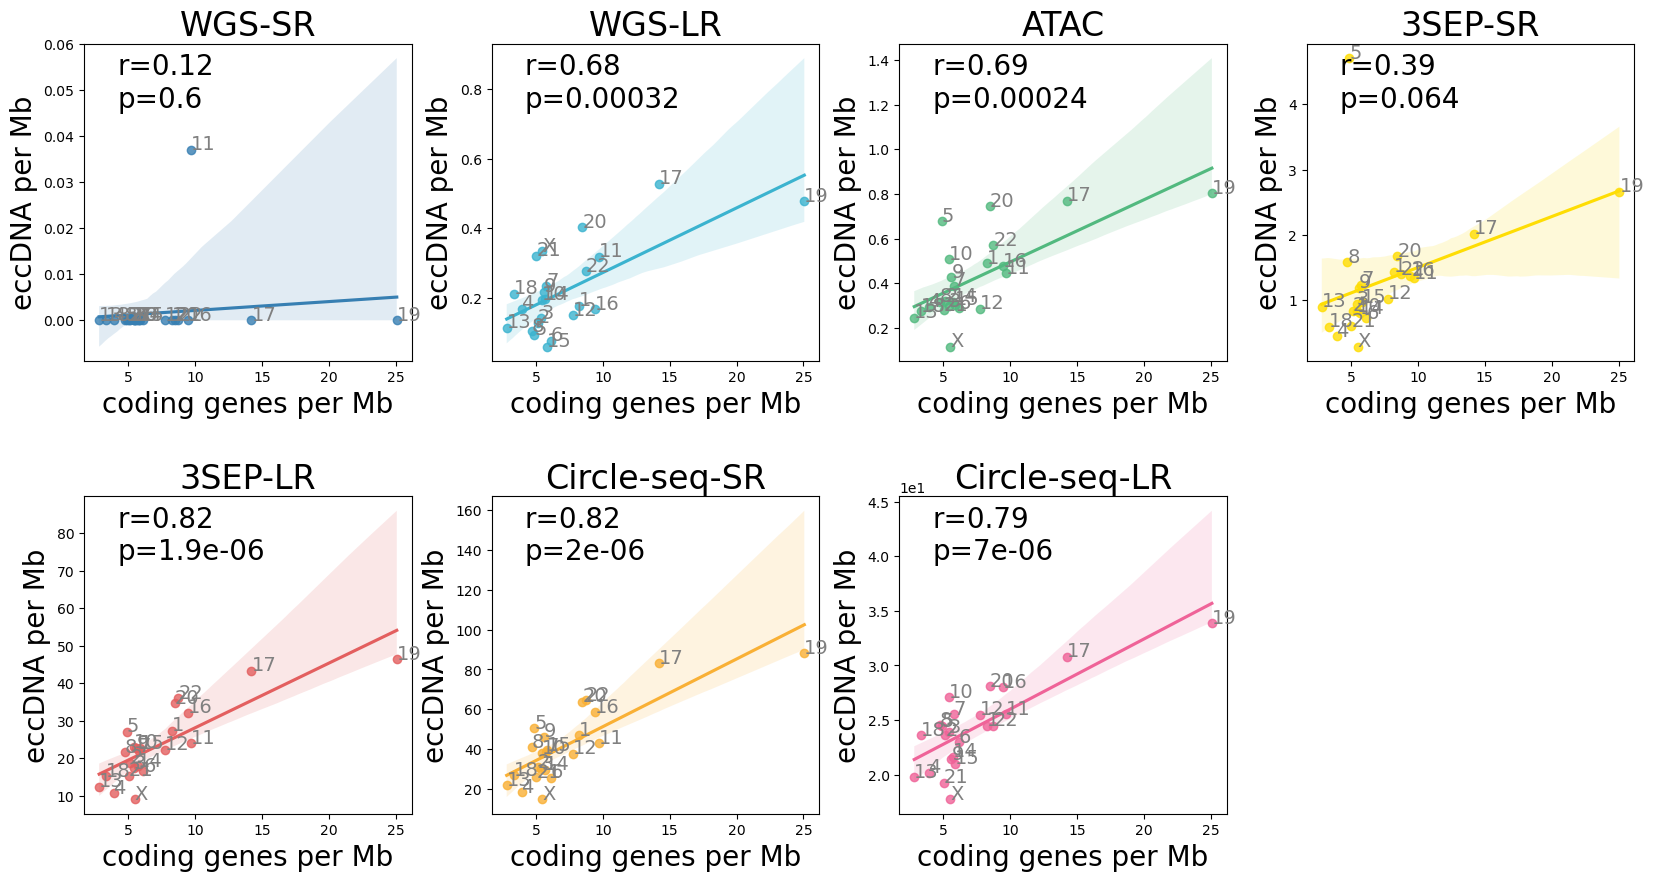

In [19]:
#sns.scatterplot(density_plot,x='coding_gene',y='DNRT7')
fig = plt.figure(figsize=(20,10))
fig = gs.GridSpec(12, 20, hspace=0.1, wspace=60)
for i in range(1,8):
    if (i<=4):
        locals()['ax'+str(i)] = plt.subplot(fig[0:5,5*i-5:5*i])
    else:
        locals()['ax'+str(i)] = plt.subplot(fig[7:12,5*(i-5):5*i-20])
for i in range(7):
    sns.regplot(density_plot,x='coding_gene',y=protocols[i],color=palette[protocols[i]], ax=locals()['ax'+str(i+1)])
    r, p = sci.stats.pearsonr(density_plot['coding_gene'], density_plot[protocols[i]])
    locals()['ax'+str(i+1)].text(.1, .8, 'r={:.2f}\np={:.2g}'.format(r, p),transform=locals()['ax'+str(i+1)].transAxes, fontsize=20, color='black')
    locals()['ax'+str(i+1)].set_xlabel('coding genes per Mb', fontsize=20)
    locals()['ax'+str(i+1)].set_ylabel('eccDNA per Mb', fontsize=20)
    plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    locals()['ax'+str(i+1)].set_title(methods[i], fontsize=24, color='black')
    for j in ['chr{0}'.format(a) for a in list(range(1,23))+['X']]:
        locals()['ax'+str(i+1)].text(density_plot.loc[j,'coding_gene'], density_plot.loc[j,protocols[i]], j[3:], horizontalalignment='left', fontsize=14, color='gray')
plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/figure2e_gene_eccDNA_density.pdf', dpi=2000, bbox_inches='tight')